# Experimental portfolio
The work plan is
1. Download some assets' stock price data: NVDA, GOOGL, CSSPX.MI, UCG.MI, ISP.MI, CSSX5E.MI
2. Download EURUSD=X exchange rate
3. Convert stocks' dollar prices to euro
4. Plot stocks' prices in €
5. Simple moving averages for NVDA and crossover trading strategy
6. Counting the number of events with a change in NVDA price above a threshold, in absolute value. 
7. Calculate the returns
8. Set the assets' weights in the portfolio
9. Calculate the portfolio mean return
10. Calculate the portfolio covariance matrix

In [1]:
# Core numerical computing
import numpy as np
import pandas as pd

# For financial data
import yfinance as yf       # Loading financial data

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')
print('NumPy version: {}'.format(np.__version__))
print('Pandas version: {}'.format(pd.__version__))
print('Seaborn version: {}'.format(sns.__version__))
print('YFinance version: {}'.format(yf.__version__))

NumPy version: 1.26.4
Pandas version: 2.2.2
Seaborn version: 0.13.2
YFinance version: 0.2.65


## 1. Downloading the stock prices
We download the price time series for a number of stocs. The NVDA and GOOGL prices are in USD, the others in EUR.

In [3]:
start_day = '2024-01-01'
end_day = '2025-10-14'
date_index = pd.date_range(start_day, end_day)

In [4]:
stocks_list = ['NVDA', 'GOOGL', 'CSSPX.MI', 'UCG.MI', 'ISP.MI']
stocks = yf.download(stocks_list, start=start_day, end=end_day)

[*********************100%***********************]  5 of 5 completed


In [11]:
portfolio_close_price_file = '../data/portfolio_close_price_data.csv'
stocks['Close'].to_csv(portfolio_close_price_file)
stocks = None

In [13]:
stock_prices = pd.read_csv(portfolio_close_price_file, index_col='Date')
stock_prices.head()

,CSSPX.MI,GOOGL,ISP.MI,NVDA,UCG.MI
Date,,,,,
2024-01-02,454.119995,137.223557,2.388138,48.143856,22.524326
2024-01-03,452.890015,137.968414,2.385922,47.545158,22.362345
2024-01-04,451.850006,135.455765,2.441316,47.973946,23.050764
2024-01-05,450.420013,134.800278,2.470564,49.072388,23.208244
2024-01-08,451.420013,137.888962,2.477654,52.226807,23.388224


## 2. Downloading EURUSD=X exchange rates

In [37]:
eur_usd_exchange_rate = yf.download('EURUSD=X', start=start_day, end=end_day)
eur_usd_exchange_rate.tail(3)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X
Date,,,,,
2025-10-09,1.163196,1.164958,1.154921,1.163196,0
2025-10-10,1.156644,1.162994,1.156083,1.156644,0
2025-10-13,1.160241,1.162966,1.155936,1.160241,0


In [38]:
eur_usd_close_file = '../data/eur_usd_close_data.csv'
eur_usd_exchange_rate['Close'].to_csv(eur_usd_close_file, index_label='Date')
eur_usd_exchange_rate = None

In [46]:
eur_usd = pd.read_csv(eur_usd_close_file, index_col='Date')
eur_usd.head(3)

,EURUSD=X
Date,
2024-01-01,1.105583
2024-01-02,1.103875
2024-01-03,1.094176


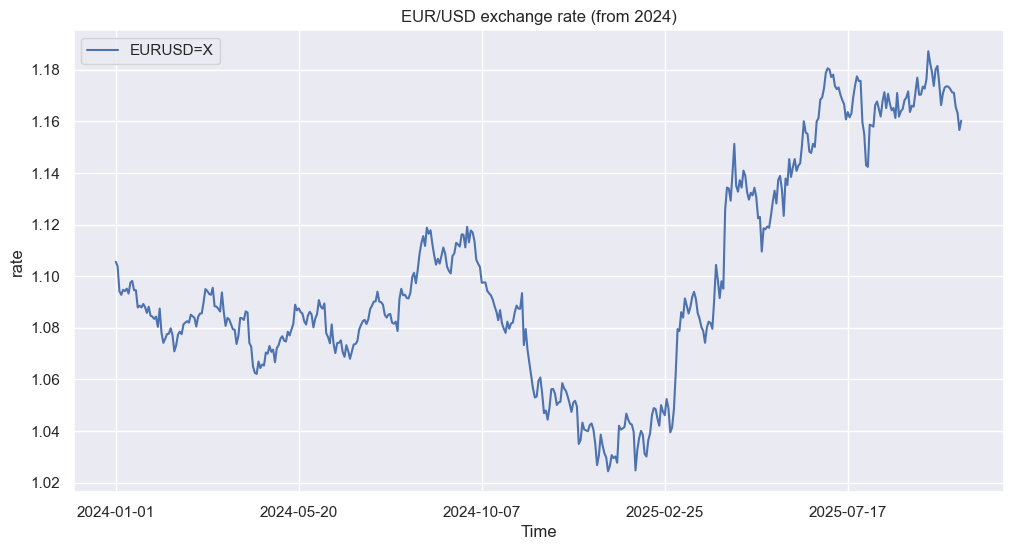

In [41]:
fig, ax = plt.subplots(figsize=(12, 6))
eur_usd.plot(ax=ax)
ax.set_title('EUR/USD exchange rate (from 2024)')
ax.set_xlabel('Time')
ax.set_ylabel('rate')
ax.legend(title="")
plt.show()

## 3. Converting stocks' dollar prices to euro

In [47]:
stock_prices['NVDA_EUR'] = np.nan
stock_prices['GOOGL_EUR'] = np.nan
for day in date_index:
    day_key = str(day.date())
    if ((day_key in stock_prices.index) and (day_key in eur_usd.index)):
        nvda_usd_price = stock_prices['NVDA'][day_key]
        googl_usd_price = stock_prices['GOOGL'][day_key]
        eur_usd_rate = eur_usd['EURUSD=X'][day_key]
        nvda_eur_price = nvda_usd_price / eur_usd_rate
        stock_prices['NVDA_EUR'][day_key] = nvda_eur_price
        googl_eur_price = googl_usd_price / eur_usd_rate
        stock_prices['GOOGL_EUR'][day_key] = googl_eur_price

In [50]:
stocks_close_eur = stock_prices.drop(['NVDA', 'GOOGL'], axis=1)
stocks_close_eur.head()

,CSSPX.MI,ISP.MI,UCG.MI,NVDA_EUR,GOOGL_EUR
Date,,,,,
2024-01-02,454.119995,2.388138,22.524326,43.613521,124.310824
2024-01-03,452.890015,2.385922,22.362345,43.452947,126.093474
2024-01-04,451.850006,2.441316,23.050764,43.900956,123.955567
2024-01-05,450.420013,2.470564,23.208244,44.825662,123.134658
2024-01-08,451.420013,2.477654,23.388224,47.729555,126.015340


## 4. Plot stocks' prices in €

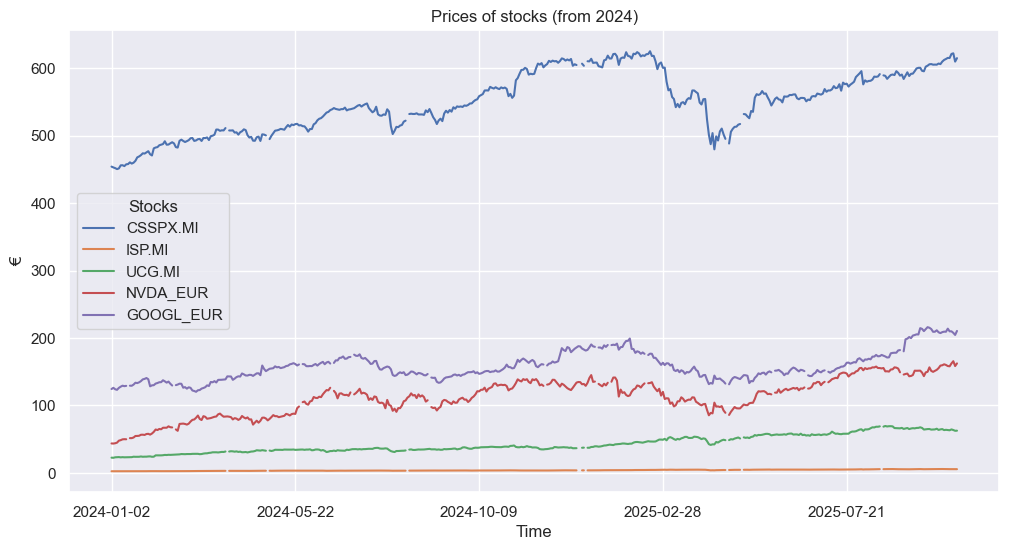

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))
stocks_close_eur.plot(ax=ax)
ax.set_title('Prices of stocks (from 2024)')
ax.set_xlabel('Time')
ax.set_ylabel('€')
ax.legend(title="Stocks")
plt.show()

## 5. NVDA moving averages an crossover trading strategy

In [52]:
stocks_close_eur['NVDA_EUR'].isna().any()

True

In [53]:
sym = 'NVDA_EUR'
nvda_eur = pd.DataFrame(stocks_close_eur[sym]).dropna()
nvda_eur.tail()

,NVDA_EUR
Date,
2025-10-07,158.014904
2025-10-08,162.262063
2025-10-09,165.552438
2025-10-10,158.354644
2025-10-13,162.311128


In [54]:
window = 20  
nvda_eur['mean'] = nvda_eur[sym].rolling(window=window).mean()  
nvda_eur['std'] = nvda_eur[sym].rolling(window=window).std()
nvda_eur['median'] = nvda_eur[sym].rolling(window=window).median()
nvda_eur['min'] = nvda_eur[sym].rolling(window=window).min()  
nvda_eur['max'] = nvda_eur[sym].rolling(window=window).max()  
nvda_eur.dropna().head()

,NVDA_EUR,mean,std,median,min,max
Date,,,,,,
2024-01-30,57.910104,51.302562,4.840767,51.492004,43.452947,57.910104
2024-01-31,56.712994,51.957535,4.627146,51.966566,43.452947,57.910104
2024-02-01,58.307927,52.700284,4.375560,53.545021,43.900956,58.307927
2024-02-02,60.808270,53.545650,4.216405,54.697912,44.825662,60.808270
2024-02-05,64.282909,54.518513,4.341384,54.870694,47.729555,64.282909


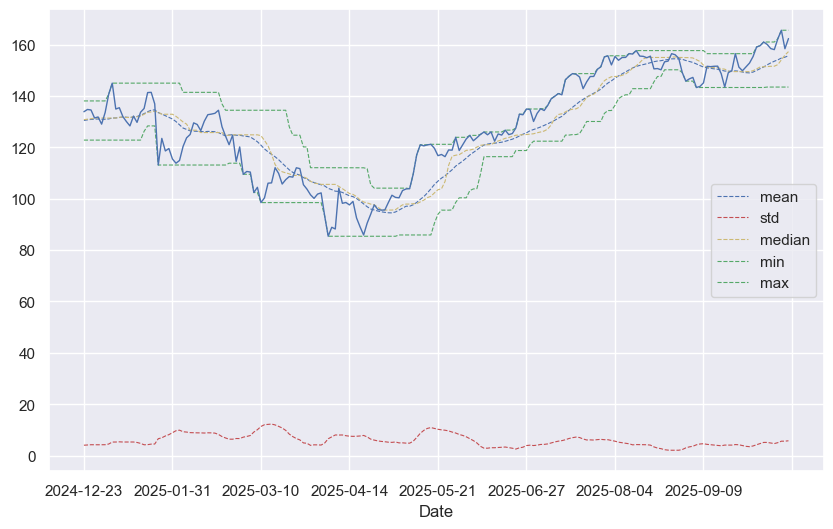

In [55]:
ax = nvda_eur[['mean', 'std', 'median', 'min', 'max']].iloc[-200:].plot(figsize=(10, 6), style=['b--', 'r--', 'y--', 'g--', 'g--'], lw=0.8)  
nvda_eur[sym].iloc[-200:].plot(ax=ax, lw=1.0); 

In [56]:
nvda_eur['SMA_Short_term'] = nvda_eur[sym].rolling(window=50).mean()
nvda_eur['SMA_Long_term'] = nvda_eur[sym].rolling(window=200).mean()

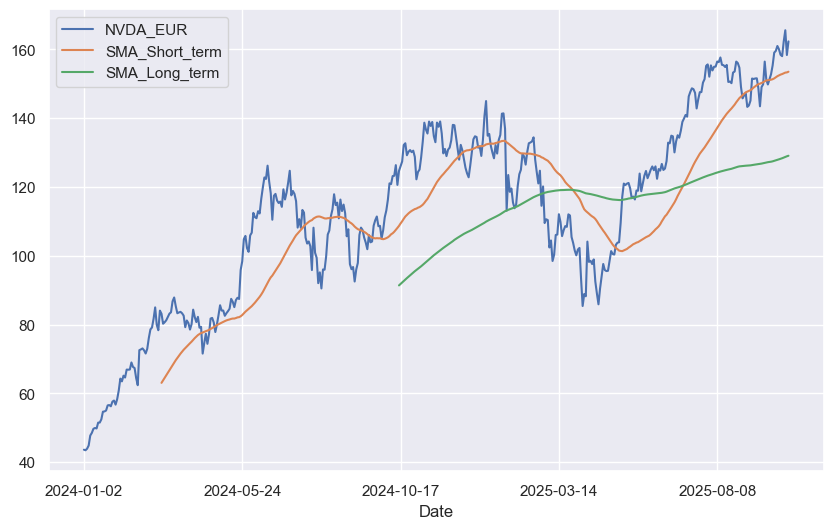

In [57]:
nvda_eur[[sym, 'SMA_Short_term', 'SMA_Long_term']].plot(figsize=(10, 6));  

We add the intervals where there is a crossover, that is where the short-term SMA lies above the long-term SMA to the data frame. We use 1 for the long position (buy) and -1 for the short one (sell).

In [58]:
nvda_eur.dropna(inplace=True)
nvda_eur['positions'] = np.where(nvda_eur['SMA_Short_term'] > nvda_eur['SMA_Long_term'], 1, -1) 

Text(0.5, 1.0, 'NVDA crossover trading strategy')

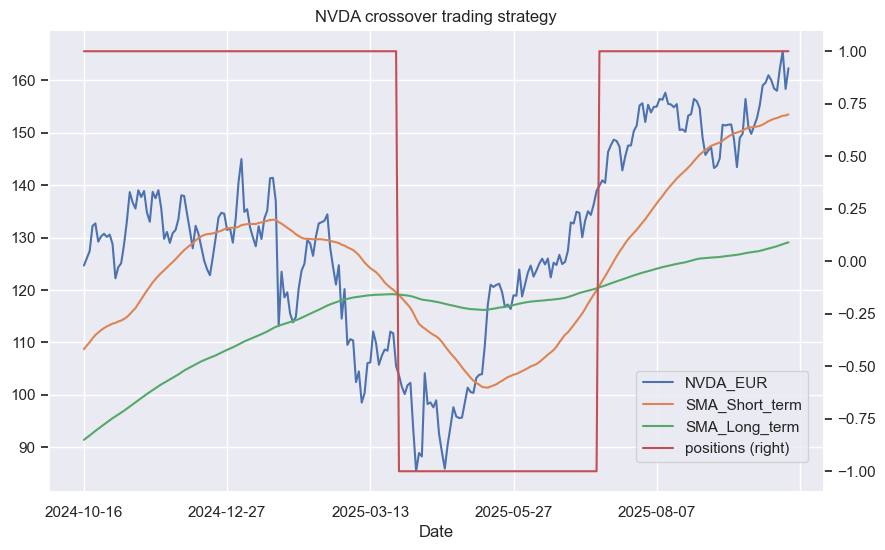

In [59]:
ax = nvda_eur[[sym, 'SMA_Short_term', 'SMA_Long_term', 'positions']].plot(figsize=(10, 6), secondary_y='positions')
ax.get_legend().set_bbox_to_anchor((0.99, 0.28));
ax.set_title('NVDA crossover trading strategy')